# Eigenstates


The linear response TDDFT equations involves the solution of a non-Hermitian eigenvalue equation which can be written as

$$
\left(
\begin{array}{cc}
\mathbf{A} & \mathbf{B} \\
\mathbf{B}^* & \mathbf{A}^*
\end{array}
\right) 
\left(
\begin{array}{c}
\mathbf{X} \\
\mathbf{Y}
\end{array}
\right) 
= \omega
\left(
\begin{array}{cc}
\mathbf{1} & \mathbf{0} \\
\mathbf{0}^* & \mathbf{-1}^*
\end{array}
\right) 
\left(
\begin{array}{c}
\mathbf{X} \\
\mathbf{Y}
\end{array}
\right) 
$$

From this, excitation energies and transition amplitudes are obtained from the eigenvalues and corresponding eigenvectors, respectively.

## Example: ethylene

In [1]:
import py3Dmol as p3d
import veloxchem as vlx
import matplotlib.pyplot as plt
import numpy as np
from valet import transition_analysis_utils as tau

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [2]:
ethene_xyz = """6

C        0.67759997    0.00000000    0.00000000
C       -0.67759997    0.00000000    0.00000000
H        1.21655197    0.92414474    0.00000000
H        1.21655197   -0.92414474    0.00000000
H       -1.21655197   -0.92414474    0.00000000
H       -1.21655197    0.92414474    0.00000000
"""

In [3]:
viewer = p3d.view(width=400, height=300)
viewer.addModel(ethene_xyz)
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
molecule = vlx.Molecule.from_xyz_string(ethene_xyz)
basis = vlx.MolecularBasis.read(molecule, "STO-3G")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /home/thomas/miniconda3/envs/echem/lib/python3.10/site-packages/veloxchem/basis/STO-3G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
              

We can extract the MO energies, number of occupied and unoccupied MOs, and the HOMO-LUMO gap:

In [5]:
mo_energy = scf_results["E_alpha"]
nocc = molecule.number_of_alpha_electrons()
norb = mo_energy.shape[0]
nvirt = norb - nocc

print("Number of orbitals:", len(mo_energy))
print("Number of occupied orbitals:", nocc)
print("Number of virtual orbitals:", nvirt)
print("\nMO energies (au):\n", mo_energy)

print(f"\nHOMO-LUMO gap (eV): {27.2114*(mo_energy[nocc+1] - mo_energy[nocc]):.3f}")

Number of orbitals: 14
Number of occupied orbitals: 8
Number of virtual orbitals: 6

MO energies (au):
 [-11.01836831 -11.01770512  -0.97499968  -0.74974532  -0.60873828
  -0.52384446  -0.47291168  -0.31833759   0.31057108   0.65779903
   0.69521875   0.70654116   0.95189253   0.95926696]

HOMO-LUMO gap (eV): 9.449


Looking at the MOs:

In [6]:
viewer = vlx.OrbitalViewer()
viewer.plot(molecule, basis, scf_drv.mol_orbs)

Output()

Dropdown(description='Orbital:', index=7, options=(('  1 occ=2.000 ene=-11.018', 0), ('  2 occ=2.000 ene=-11.0…

## Eigenstates

We first perform a reference calculation using `LinearResponseEigenSolver`, where we calculate the first 12 excited states using a reduced-space Davidson algorithm which can resolve the N lowest eigenvalues (bottom-up).:

In [8]:
lres_drv = vlx.LinearResponseEigenSolver()
rsp_settings = {"nstates": 12}
lres_drv.update_settings(rsp_settings)
lres_out = lres_drv.compute(molecule, basis, scf_results)

                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 12                                                       
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

The output contains

In [ ]:
lres_out.keys()

We create a function for printing the results (energy, oscillator strength, transition moment) in a table:

In [9]:
def print_table(lres):
    print("State Energy [eV]  Osc. str.   TM(x)     TM(y)     TM(z)")
    for i in np.arange(len(lres["eigenvalues"])):
        e, os, x, y, z = (
            27.2114 * lres["eigenvalues"][i],
            lres["oscillator_strengths"][i],
            lres["electric_transition_dipoles"][i][0],
            lres["electric_transition_dipoles"][i][1],
            lres["electric_transition_dipoles"][i][2],
        )
        print(f" {i:2}     {e:.3f}     {os:8.5f}  {x:8.5f}  {y:8.5f}  {z:8.5f}")

print_table(lres_out)

State Energy [eV]  Osc. str.   TM(x)     TM(y)     TM(z)
  0     10.028      0.48947   1.41149  -0.00000  -0.00000
  1     10.771      0.00000  -0.00000  -0.00000   0.00000
  2     11.406      0.00000   0.00000   0.00000  -0.00000
  3     14.599      0.00000  -0.00000   0.00000   0.00000
  4     16.272      0.00000   0.00000   0.00000  -0.00000
  5     18.112      0.00000  -0.00000  -0.00000  -0.00011
  6     18.892      0.00000  -0.00000   0.00000   0.00000
  7     20.557      0.48591   0.00000  -0.00000   0.98224
  8     21.544      0.00000   0.00000  -0.00000   0.00000
  9     22.435      0.03604  -0.00000  -0.25605  -0.00000
 10     22.762      1.20100  -1.46754   0.00000   0.00000
 11     22.846      0.00000   0.00000  -0.00000  -0.00000


These results were obtained using the solver in VeloxChem, and we will now calculate this explicitly by using the Hessian, overlap matrix, and property gradients.

### Electronic Hessian

The electronic Hessian, $\mathbf{E}^{[2]}$ reads

\begin{equation*}
\mathbf{E}^{[2]} =
	\begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
	\rule{5pt}{0pt}
	\mathbf{A} & \mathbf{B} \rule{5pt}{0pt}
	\\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
	\mathbf{B}^* & \mathbf{A}^* \\
	\end{pmatrix}
\end{equation*}

For a general hybrid functional, the blocks are constructed as:

\begin{align*}
A_{ia,jb}  &= \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) + (ia|jb) - c_{\textrm{HF}}(ij|ab) + (1-c_{\textrm{HF}})(ia|f_{\textrm{xc}}|jb)
\\
B_{ia,jb}  &= (ia|bj) - c_{\textrm{HF}}(ib|aj) + (1-c_{\textrm{HF}})(ia|f_{\textrm{xc}}|bj)
\end{align*}

For a closed-shell system, the dimension of the $\mathbf{A}$- and $\mathbf{B}$-blocks of the $\mathbf{E}^{[2]}$-matrix equals the number of occupied (spatial) orbitals times the number of virtual orbitals or, in other words

$$\mathrm{dim}\left(\mathbf{E}^{[2]}\right) = 2 \times n_\mathrm{occ} \times n_\mathrm{virt}$$

In the limits we retrieve the TDHF blocks ($c_{\textrm{HF}} = 1$) and pure TDDFT ($c_{\textrm{HF}} = 0$). It can be noted that:

- The matrix is Hermitian and has an internal structure in terms of the matrix blocks $\mathbf{A}$ and $\mathbf{B}$, but not in the full form
- The diagonal elements correspond to differences in energy between the single-excited determinants $|0_i^a\rangle$ and the reference state $|0\rangle$

We get the $\mathbf{E}^{[2]}$-matrix from the `LinearResponseEigenSolver` class object.

In [10]:
lres_drv = vlx.LinearResponseEigenSolver()
E2 = lres_drv.get_e2(molecule, basis, scf_results)

* Info * Processing Fock builds... (batch size: 192)                                                                      
* Info *   batch 1/1                                                                                                      


The dimension of the Hessian should be

In [11]:
n = nocc * nvirt
print("Dimension of full Hessian:", 2 * n)

Dimension of full Hessian: 96


Which is verified using `.shape`

In [12]:
print(E2.shape)

(96, 96)


This is a bit too large to print, but we can visualize the matrix using `imshow`:

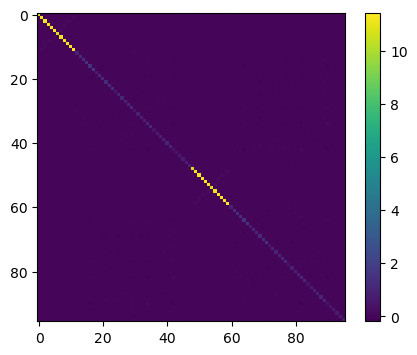

In [13]:
plt.figure(figsize=(5, 4))
plt.imshow(E2)
plt.colorbar()
plt.show()

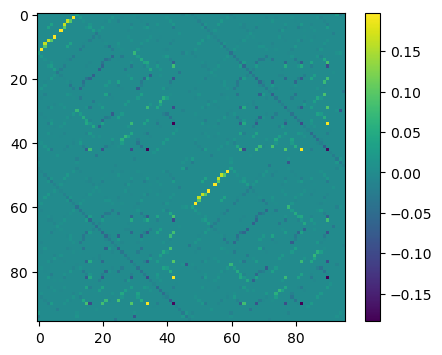

In [14]:
plt.figure(figsize=(5, 4))
plt.imshow(np.array(E2) - np.array(E2)*np.identity(96))
plt.colorbar()
plt.show()

## Overlap matrix


The overlap matrix, $\mathbf{S}^{[2]}$, in the SCF approximation is trivial and equal to

$$
\mathbf{S}^{[2]}  =
	\begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
	\rule{5pt}{0pt}
	\mathbf{1} & \mathbf{0} \rule{5pt}{0pt}
	\\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
	\mathbf{0} & -\mathbf{1} \\
	\end{pmatrix}
$$

where $\mathbf{1}$ and the $\mathbf{1}$ are understood to be the identity and zero matrices, respectively, of the same rank as sub-blocks $\mathbf{A}$ and $\mathbf{B}$ in the electronic Hessian. We construct this as

In [15]:
S2 = np.identity(2 * n)
S2[n:, n:] *= -1

## Property gradient


In the SCF approximation, the property gradient, $\mathbf{V}^{[1]}$, takes the form

\begin{equation*}
  \mathbf{V}^{[1]} =
      \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    \mathbf{g}
       \\
    \rule[-5pt]{0pt}{0pt}
     -\mathbf{g}^*
\\
  \end{pmatrix}
\end{equation*}

We get the $\mathbf{V}^{\omega,[1]}$-vector from the `LinearResponseSolver` class object. We assume the perturbation operator to equal minus the electric dipole moment operator along the $x$-axis, i.e., the molecular C$-$C axis.

In [16]:
lrs_drv = vlx.LinearResponseSolver()

mu_x = lrs_drv.get_prop_grad("electric dipole", "x", molecule, basis, scf_results)[0]
mu_y = lrs_drv.get_prop_grad("electric dipole", "y", molecule, basis, scf_results)[0]
mu_z = lrs_drv.get_prop_grad("electric dipole", "z", molecule, basis, scf_results)[0]

V1x = -mu_x
V1y = -mu_y
V1z = -mu_z

print("Dimension of V[1] vectors:", V1x.shape[0])

Dimension of V[1] vectors: 96


We can illustrate these vectors as

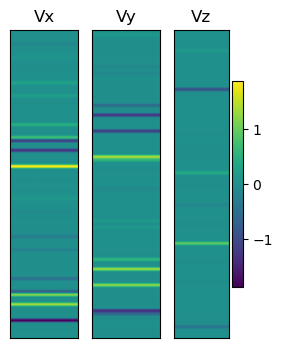

In [17]:
plt.figure(figsize=(3, 4))
Vmtrx = np.zeros((2 * n, 100))
plt.subplot(131)
plt.title("Vx")
for i in np.arange(100):
    Vmtrx[:, i] = V1x
plt.imshow(
    Vmtrx, vmin=np.min([V1x, V1y, V1z]), vmax=np.max([V1x, V1y, V1z]), aspect="auto"
)
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.title("Vy")
for i in np.arange(100):
    Vmtrx[:, i] = V1y
plt.imshow(
    Vmtrx, vmin=np.min([V1x, V1y, V1z]), vmax=np.max([V1x, V1y, V1z]), aspect="auto"
)
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.title("Vz")
for i in np.arange(100):
    Vmtrx[:, i] = V1z
plt.imshow(
    Vmtrx, vmin=np.min([V1x, V1y, V1z]), vmax=np.max([V1x, V1y, V1z]), aspect="auto"
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

## Calculating excitation energies

Denote the eigenvectors of the generalized eigenvalue equation as $\mathbf{X}_e$

$$
  \mathbf{E}^{[2]} \mathbf{X}_e = \lambda_e \mathbf{S}^{[2]} \mathbf{X}_e, \quad e = -n,\ldots,-1,1,\ldots,n ,
$$
 
where the matrix dimension is $2n$. We find the set of eigenvalues and eigenvectors by diagonalizing the non-Hermitian matrix $\left(\mathbf{S}^{[2]}\right)^{-1} \mathbf{E}^{[2]}$

$$
  \mathbf{X}^{-1} \left[ \left(\mathbf{S}^{[2]}\right)^{-1} \mathbf{E}^{[2]} \right] \mathbf{X} = 
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{9pt}{0pt}
    \boldsymbol{\lambda} & \rule{3pt}{0pt} \mathbf{0} \rule{3pt}{0pt} \\
    \rule{3pt}{0pt}
    \mathbf{0} & -\boldsymbol{\lambda} \rule{3pt}{0pt} \\
  \end{bmatrix}
$$

where $\boldsymbol{\lambda}$ is a diagonal matrix of dimension $n$ collecting the eigenvalues with positive index and the columns of $\mathbf{X}$ store the eigenvectors ($\mathbf{X}$ is assumed to be nonsingular). This pairing of eigenvalues has its correspondence in the eigenvectors through

\begin{align*}
  \mathbf{X}_e &=
  \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    \mathbf{Z}_e \\
    \rule[-5pt]{0pt}{0pt}
    \mathbf{Y}_e^* \\
  \end{pmatrix}
\; \mbox{with eigenvalue}\; \lambda_e \\
  \mathbf{X}_{-e} &=
  \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    \mathbf{Y}_{e} \\
    \rule[-5pt]{0pt}{0pt}
    \mathbf{Z}_{e}^* \\
  \end{pmatrix} 
\; \mbox{with eigenvalue}\; -\!\lambda_e 
\end{align*}

The matrix $\mathbf{X}$ will therefore have the structure

\begin{equation*}
  \mathbf{X} = 
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{3pt}{0pt}
    \mathbf{Z} & \rule{3pt}{0pt} \mathbf{Y} \rule{3pt}{0pt} \\
    \rule{8pt}{0pt}
    \mathbf{Y}^* & \rule{3pt}{0pt} \mathbf{Z}^* \rule{3pt}{0pt} \\
  \end{bmatrix}
\end{equation*}

With an appropriate scaling of the eigenvectors $\mathbf{X}_e$, the non-unitary matrix $\mathbf{X}$ achieves a simultaneous diagonalization of the two non-commuting matrices $\mathbf{E}^{[2]}$ and $\mathbf{S}^{[2]}$ as

$$
  \mathbf{X}^\dagger \mathbf{E}^{[2]} \mathbf{X} = 
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{9pt}{0pt}
    \boldsymbol{\lambda} & \rule{3pt}{0pt} \mathbf{0} \rule{3pt}{0pt} \\
    \rule{3pt}{0pt}
    \mathbf{0} & \boldsymbol{\lambda} \rule{3pt}{0pt} \\
  \end{bmatrix} ; \qquad
  \mathbf{X}^\dagger \mathbf{S}^{[2]} \mathbf{X} =
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{8pt}{0pt}
    \mathbf{1} & \rule{5pt}{0pt} \mathbf{0} \rule{3pt}{0pt} \\
    \rule{5pt}{0pt}
    \mathbf{0} & -\mathbf{1} \rule{3pt}{0pt} \\
  \end{bmatrix} 
$$

For each pair of eigenvectors, the second equation involving the metric of the generalized eigenvalue equation defines which of the two that should be indexed with a positive index. We also emphasize that $\mathbf{X}^\dagger \neq \mathbf{X}^{-1}$ and for this reason the $\mathbf{X}_e$'s are eigenvectors neither of $\mathbf{E}^{[2]}$ nor of $\mathbf{S}^{[2]}$, just as the $\lambda_e$'s are not the eigenvalues of $\mathbf{E}^{[2]}$.

The eigenvalues, or excitation energies, can then be calculated by use of `np.linalg.eig` on $\left(\mathbf{S}^{[2]}\right)^{-1} \mathbf{E}^{[2]}$. This will return the eigenvalues and eigenvectors, which can then be reordered:

In [19]:
eigs, X = np.linalg.eig(np.matmul(np.linalg.inv(S2), E2))

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]
# print first 12 positive eigenvalues:
print(eigs[n : n + 12])

# print(f'Excitation energy (au): {eigs[idx] : .6f}')
print("Reference:\n", lres_out["eigenvalues"])

[0.36852357 0.39582117 0.41914496 0.53648534 0.59799821 0.66561384
 0.694277   0.75545073 0.79173677 0.82446474 0.8364707  0.83957699]
Reference:
 [0.36852357 0.39582117 0.41914496 0.53648534 0.59799821 0.66561384
 0.694277   0.75545073 0.79173677 0.82446474 0.8364707  0.83957699]


## Calculating intensities

Transition moments in the SCF approximation take the form

$$
    \langle n | \hat{V} | 0 \rangle =
    \mathbf{X}^\dagger_f \mathbf{V}^{\omega,[1]}
$$

The oscillator strength is then calculated as

In [20]:
def compute_fosc(eigs, X, V1x, V1y, V1z, S2):
    fosc = []
    for i in range(len(eigs)):
        if eigs[i] > 0.0:  # only for positive eigenvalues
            Xf = X[:, i]
            Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
            tm = np.dot(Xf, V1x) ** 2 + np.dot(Xf, V1y) ** 2 + np.dot(Xf, V1z) ** 2
            fosc.append(tm * 2.0 / 3.0 * eigs[i])
    return fosc


fosc = compute_fosc(eigs, X, V1x, V1y, V1z, S2)

In [21]:
print("Oscillator strengths:\n", np.around(fosc[:12], 6))
print("\nReference:\n", np.around(lres_out["oscillator_strengths"], 6))

Oscillator strengths:
 [0.489474 0.       0.       0.       0.       0.       0.       0.485906
 0.       0.036035 1.200997 0.      ]

Reference:
 [0.489474 0.       0.       0.       0.       0.       0.       0.485906
 0.       0.036035 1.200997 0.      ]


## Analysis

We are finally ready to compare our excitation energies to experiment, and we can first print our HF/STO-3G results as:

In [22]:
print_table(lres_out)

State Energy [eV]  Osc. str.   TM(x)     TM(y)     TM(z)
  0     10.028      0.48947   1.41149  -0.00000  -0.00000
  1     10.771      0.00000  -0.00000  -0.00000   0.00000
  2     11.406      0.00000   0.00000   0.00000  -0.00000
  3     14.599      0.00000  -0.00000   0.00000   0.00000
  4     16.272      0.00000   0.00000   0.00000  -0.00000
  5     18.112      0.00000  -0.00000  -0.00000  -0.00011
  6     18.892      0.00000  -0.00000   0.00000   0.00000
  7     20.557      0.48591   0.00000  -0.00000   0.98224
  8     21.544      0.00000   0.00000  -0.00000   0.00000
  9     22.435      0.03604  -0.00000  -0.25605  -0.00000
 10     22.762      1.20100  -1.46754   0.00000   0.00000
 11     22.846      0.00000   0.00000  -0.00000  -0.00000


Assigning transitions can be done by considering, *e.g.*:
- The polarization of the transition
- Contributing MOs
- ...

This afternoon we will discuss natural transition orbitals (NTOs), which provide a convenient tool for studying the character of excited states, but for now we can consider the MO amplitudes dominating each transition:

In [23]:
for i in np.arange(len(lres_out["excitation_details"])):
    print(f"State {i:2}:", lres_out["excitation_details"][i])

State  0: ['HOMO     -> LUMO         0.9905']
State  1: ['HOMO-2   -> LUMO        -0.9925']
State  2: ['HOMO-1   -> LUMO        -0.9986']
State  3: ['HOMO-3   -> LUMO         0.9999']
State  4: ['HOMO     -> LUMO+1      -0.9985']
State  5: ['HOMO     -> LUMO+2       0.9130', 'HOMO-4   -> LUMO         0.4083']
State  6: ['HOMO     -> LUMO+3       0.9894']
State  7: ['HOMO-4   -> LUMO        -0.9134', 'HOMO     -> LUMO+2       0.4083']
State  8: ['HOMO     -> LUMO+4      -0.9948']
State  9: ['HOMO-2   -> LUMO+1       0.8927', 'HOMO-1   -> LUMO+3       0.3249', 'HOMO-3   -> LUMO+2      -0.2457']
State 10: ['HOMO-1   -> LUMO+1       0.9826']
State 11: ['HOMO-1   -> LUMO+2       0.9182', 'HOMO-3   -> LUMO+3      -0.3860']


We see that the first transition, which has the polarization of the sought state, is strongly dominated by a HOMO-LUMO transition. Looking at the MOs:

In [24]:
viewer = vlx.OrbitalViewer()
viewer.plot(molecule, basis, scf_drv.mol_orbs)

Output()

Dropdown(description='Orbital:', index=7, options=(('  1 occ=2.000 ene=-11.018', 0), ('  2 occ=2.000 ene=-11.0…

We can see that this is an intense $\pi \rightarrow \pi^*$ transition. The excitation energy is seen to be just above 10 eV, so quite a bit above experiment ($\sim$7.7 eV). This is due to the use of TDHF and the very limited basis set.